## 기본설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/Shareddrives/행복 범주 화이팅!/image

/content/drive/Shareddrives/행복 범주 화이팅!/image


# 데이터 불러오기 및 전처리

In [3]:
import os
import cv2 
import pandas as pd 
import numpy as np

img_data = pd.read_csv("/content/drive/Shareddrives/행복 범주 화이팅!/data/최종이미지.csv" )
img_name = list(np.array(img_data['0'].tolist()))

import re
for i in range(0,len(img_name)):
  img_name[i] = re.sub('[\ /  * ? " < > |]', ' ', str(img_name[i]))

 #\ / : * ? " < > |

# 이미지 처리 함수 생성

In [17]:
import tensorflow as tf

import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12,12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [18]:
def tensor_to_image(tensor):
  tensor = tensor*255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [19]:
def load_img(path_to_img):
  max_dim = 512
  img = tf.io.read_file(path_to_img)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.convert_image_dtype(img, tf.float32)

  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim

  new_shape = tf.cast(shape * scale, tf.int32)

  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

In [20]:
def imshow(image, title=None):
  if len(image.shape) > 3:
    image = tf.squeeze(image, axis=0)

  plt.imshow(image)
  if title:
    plt.title(title)

In [21]:
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')

print()
for layer in vgg.layers:
  print(layer.name)


input_3
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_conv4
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_conv4
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_conv4
block5_pool


In [22]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

#num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [23]:
def vgg_layers(layer_names):
  """ 중간층의 출력값을 배열로 반환하는 vgg 모델을 만듭니다."""
  # 이미지넷 데이터셋에 사전학습된 VGG 모델을 불러옵니다
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False

  outputs = [vgg.get_layer(name).output for name in layer_names]

  model = tf.keras.Model([vgg.input], outputs)
  return model

In [24]:
style_extractor = vgg_layers(style_layers)

In [25]:
def gram_matrix(input_tensor):
  result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)
  num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
  return result/(num_locations)

In [26]:
class StyleContentModel(tf.keras.models.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleContentModel, self).__init__()
    self.vgg =  vgg_layers(style_layers + content_layers)
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.num_style_layers = len(style_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    "[0,1] 사이의 실수 값을 입력으로 받습니다"
    inputs = inputs*255.0
    preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
    outputs = self.vgg(preprocessed_input)
    style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                      outputs[self.num_style_layers:])

    style_outputs = [gram_matrix(style_output)
                     for style_output in style_outputs]

    content_dict = {content_name:value 
                    for content_name, value 
                    in zip(self.content_layers, content_outputs)}

    style_dict = {style_name:value
                  for style_name, value
                  in zip(self.style_layers, style_outputs)}

    return {'content':content_dict, 'style':style_dict}

In [27]:
from sklearn.manifold import TSNE
from matplotlib.offsetbox import OffsetImage, AnnotationBbox, TextArea

In [28]:
def imscatter(x, y, image, ax=None, zoom=1, show_by_thumnail=False, title='webtoon'):
    if ax is None:
        ax = plt.gca()
    try:
        image = plt.imread(image)
    except TypeError:
        # Likely already an array...
        pass
    im = OffsetImage(image, zoom=zoom)

    # Convert inputs to arrays with at least one dimension.
    x, y = np.atleast_1d(x, y)
    
    artists = []
    for x0, y0 in zip(x, y):
        ab = AnnotationBbox(im, (x0, y0), xycoords='data', frameon=False)
        

        if show_by_thumnail:
          offsetbox = TextArea(title, minimumdescent=False)
          ac = AnnotationBbox(offsetbox, (x0, y0),
                      xybox=(20, -40),
                      xycoords='data',
                      boxcoords="offset points")
          artists.append(ax.add_artist(ac))
        artists.append(ax.add_artist(ab))

    ax.update_datalim(np.column_stack([x, y]))
    ax.autoscale()
    return artists

In [29]:
 class StyleContentModel(tf.keras.models.Model):
      def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg =  vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

      def call(self, inputs):
        "[0,1] 사이의 실수 값을 입력으로 받습니다"
        inputs = inputs*255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers], 
                                          outputs[self.num_style_layers:])

        style_outputs = [gram_matrix(style_output)
                        for style_output in style_outputs]

        content_dict = {content_name:value 
                        for content_name, value 
                        in zip(self.content_layers, content_outputs)}

        style_dict = {style_name:value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        return {'content':content_dict, 'style':style_dict}

# 살려주세요

In [30]:
import os
os.chdir("/content/drive/Shareddrives/행복 범주 화이팅!/image_vector")
vec = pd.read_csv('vector31334.csv')

In [31]:
ani_name = list(np.array(vec['img_name'].tolist()))

In [35]:
name=ani_name[0] #"귀멸의 칼날"
change_index_lst=[]
for i in range(0,len(ani_name)):
	if ani_name[i] != name:
		change_index_lst.append(i)
		name=ani_name[i]


In [ ]:
change_index_lst[1400:] # 이걸로 끊을 범위 나눠야됨

In [37]:
# 에러뜨면 re.sub에 : 추가하고 돌리기
img_data = pd.read_csv("/content/drive/Shareddrives/행복 범주 화이팅!/data/최종이미지.csv" )
img_name = list(np.array(img_data['0'].tolist()))


import re
for i in range(0,len(img_name)):
  img_name[i] = re.sub('[\ / : * ? " < > |]', ' ', str(img_name[i]))

 #\ / : * ? " < > |

In [38]:
os.chdir("/content/drive/Shareddrives/행복 범주 화이팅!/image_vector")
df = pd.read_csv('frame.csv')
df.drop(['Unnamed: 0'],axis=1,inplace=True)

In [40]:
# 에러뜨면 style_path, c 둘 다 주석처리
#style_path = []
#c = []
k= []
n= []
temp = []
#df_v = pd.DatrFrame()
# range len(img_name)으로 바꿔줄것
os.chdir("/content/drive/Shareddrives/행복 범주 화이팅!/image")
for i in range(5256,6523):
    if i not in change_index_lst:  
  
      name = img_name[i]+'_'+str(i)+'.jpg'
      style_image = load_img(name)
      style_outputs = style_extractor(style_image*255)
    
      extractor = StyleContentModel(style_layers, content_layers)
      results = extractor(tf.constant(style_image)) 

      aw1 = np.array(list(results['style'].values())[0].numpy().reshape(-1,1) )
      aw2 = np.array(list(results['style'].values())[1].numpy().reshape(-1,1) )
      aw3 = np.array(list(results['style'].values())[2].numpy().reshape(-1,1) )
      aw4 = np.array(list(results['style'].values())[3].numpy().reshape(-1,1) )
      aw5 = np.array(list(results['style'].values())[4].numpy().reshape(-1,1) )
    

      c1 = np.concatenate([aw1,aw2,aw3,aw4,aw5]).reshape(1,-1)
      a=c1.tolist()
      b=[y for x in a for y in x]
      k.append(b)
      n.append(img_name[i])
      
      
    else:
      #여기서 데이터프레임에 행 추가를 넣고 변수 초기화하고 진행된다면?
      kkk = [sum(elts)/len(k) for elts in zip(*k)]
      s = set(n)
      l = list(s)
      kkk.insert(0,l)
      #temp.append(l)
      #temp.append(kkk)
      df.loc[i] = kkk
      n= []
      temp =[]
      k= []
      name = img_name[i]+'_'+str(i)+'.jpg'
      style_image = load_img(name)
      style_outputs = style_extractor(style_image*255)
    
      extractor = StyleContentModel(style_layers, content_layers)
      results = extractor(tf.constant(style_image)) 

      aw1 = np.array(list(results['style'].values())[0].numpy().reshape(-1,1) )
      aw2 = np.array(list(results['style'].values())[1].numpy().reshape(-1,1) )
      aw3 = np.array(list(results['style'].values())[2].numpy().reshape(-1,1) )
      aw4 = np.array(list(results['style'].values())[3].numpy().reshape(-1,1) )
      aw5 = np.array(list(results['style'].values())[4].numpy().reshape(-1,1) )
    
      c1 = np.concatenate([aw1,aw2,aw3,aw4,aw5]).reshape(1,-1)
      a=c1.tolist()
      b=[y for x in a for y in x]
      k.append(b)
      n.append(img_name[i])
      

# 데이터 프레임 만들시에 같은 차원의 데이터 프레임 만들어 놓고 그 아래 행을 계속
# append 하는식으로 가야할 거 같음 
#그러려면 list 하나를 [애니 이름, 그램행렬들평균~~~] 이런식으로 데이터프레임 열과 길이 맞추면 가능?
    
    
    
    
    
    
    #df.loc[i] =kkk
    #if n[-1] != n[-2]:
    #c.append(c1)
    print(img_name[i]+'_'+str(i)+'완료')
    
    #globals()['c{}'.format(i)] = np.concatenate([aw1,aw2,aw3,aw4,aw5]).reshape(1,-1)
    #c.append('c{}'.format(i))
#kkk = [sum(elts)/len(k) for elts in zip(*k)]
#temp.append(kkk)
#df1 = pd.DataFrame({'name':n})
#df2 = pd.DataFrame(k)
#df3 = pd.concat([df1,df2],axis=1)

os.chdir("/content/drive/Shareddrives/행복 범주 화이팅!/real_img_vec ")
df.drop([0],inplace=True)
df.to_csv('df_b_1.csv',encoding='utf-8-sig')
print('끝')


곰 곰 곰 베어_5256완료
곰 곰 곰 베어_5257완료
곰 곰 곰 베어_5258완료
곰 곰 곰 베어_5259완료
곰 곰 곰 베어_5260완료
곰 곰 곰 베어_5261완료
곰 곰 곰 베어_5262완료
곰 곰 곰 베어_5263완료
곰 곰 곰 베어_5264완료
곰 곰 곰 베어_5265완료
곰 곰 곰 베어_5266완료
다이아몬드 에이스 2기_5267완료
다이아몬드 에이스 2기_5268완료
다이아몬드 에이스 2기_5269완료
다이아몬드 에이스 2기_5270완료
다이아몬드 에이스 2기_5271완료
다이아몬드 에이스 2기_5272완료
다이아몬드 에이스 2기_5273완료
다이아몬드 에이스 2기_5274완료
다이아몬드 에이스 2기_5275완료
다이아몬드 에이스 2기_5276완료
다이아몬드 에이스 2기_5277완료
다이아몬드 에이스 2기_5278완료
다이아몬드 에이스 2기_5279완료
다이아몬드 에이스 2기_5280완료
다이아몬드 에이스 2기_5281완료
다이아몬드 에이스 2기_5282완료
다이아몬드 에이스 2기_5283완료
다이아몬드 에이스 2기_5284완료
다이아몬드 에이스 2기_5285완료
다이아몬드 에이스 2기_5286완료
다이아몬드 에이스 2기_5287완료
다이아몬드 에이스 2기_5288완료
다이아몬드 에이스 2기_5289완료
다이아몬드 에이스 2기_5290완료
다이아몬드 에이스 2기_5291완료
다이아몬드 에이스 2기_5292완료
다이아몬드 에이스 2기_5293완료
나루토 2기_5294완료
나루토 2기_5295완료
나루토 2기_5296완료
나루토 2기_5297완료
나루토 2기_5298완료
나루토 2기_5299완료
나루토 2기_5300완료
나루토 2기_5301완료
나루토 2기_5302완료
나루토 2기_5303완료
나루토 2기_5304완료
나루토 2기_5305완료
나루토 2기_5306완료
나루토 2기_5307완료
나루토 2기_5308완료
나루토 2기_5309완료
나루토 2기_5310완료
나루토 2기_5311완료
나루토 2기_5312완료
나루토 2기_5313완료
나루토 

# 연습장

In [ ]:
df3.to_csv('empty.csv',encoding='utf-8-sig')

In [ ]:
df3

NameError: ignored

In [ ]:
n= ['a','a','a','b']

In [ ]:
type(n)

list

In [ ]:
q = set(n)

In [ ]:
f = list(q)

In [ ]:
f[0]

'b'

In [ ]:
name=ani_name[0] #"귀멸의 칼날"
change_index_lst=[]
for i in range(0,len(ani_name)):
	if ani_name[i] != name:
		change_index_lst.append(i)
		name=ani_name[i]



In [ ]:
change_index_lst

In [ ]:
kkk

In [ ]:
n[0]

'(무삭제) 귀멸의 칼날'

In [ ]:
x= pd.DataFrame(temp)

In [ ]:
x.drop(index=['any i'],axis=0,inplace=True) # index=['any i]

KeyError: ignored

In [ ]:
x

""


In [ ]:
df1 =pd.DataFrame({'name':['bbbb']})

In [ ]:
pd.concat([df1,x],axis=1)

,name,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,610264,610265,610266,610267,610268,610269,610270,610271,610272,610273,610274,610275,610276,610277,610278,610279,610280,610281,610282,610283,610284,610285,610286,610287,610288,610289,610290,610291,610292,610293,610294,610295,610296,610297,610298,610299,610300,610301,610302,610303
0,bbbb,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
# 10개에 50초
df3

,name,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,610264,610265,610266,610267,610268,610269,610270,610271,610272,610273,610274,610275,610276,610277,610278,610279,610280,610281,610282,610283,610284,610285,610286,610287,610288,610289,610290,610291,610292,610293,610294,610295,610296,610297,610298,610299,610300,610301,610302,610303
0,(무삭제) 귀멸의 칼날,839.565491,84.030464,151.184250,665.668945,138.512207,269.238342,247.389648,187.326874,61.097092,85.648453,478.380737,142.270477,107.337448,201.815994,237.508575,98.623985,52.247982,304.192535,111.834824,96.274574,596.264343,531.442444,215.210358,11.408815,167.902634,112.573029,244.343445,51.285503,141.459930,276.968323,1.629246,306.369904,501.106171,112.132118,172.237244,1.971816,449.286896,14.790229,338.946228,...,1941.794678,12.084617,1116.268433,1777.977783,142.729782,425.361542,1529.035278,80.554298,546.437317,310.995911,47.802795,12.449945,2090.059082,666.468872,847.545288,940.581482,228.928879,1960.511719,6.910431,125.125244,0.000000,332.627228,1333.875488,627.176697,794.425049,246.495987,34.417393,843.941772,556.478699,986.692383,174.202728,143.141037,412.690704,820.513123,0.157773,2387.893311,660.937988,1921.729004,132.034241,3157.837158
1,(무삭제) 귀멸의 칼날,251.676834,25.152969,7.682105,348.009247,32.985500,253.584991,99.036766,107.126556,4.496988,93.411835,160.737396,112.459679,68.679108,125.311905,170.854050,20.845652,0.000000,87.853745,48.645596,0.000000,291.323303,161.012390,261.829590,16.973215,78.020805,22.394701,70.217751,1.076026,178.785294,78.920166,1.868543,0.014612,363.723419,11.051471,25.825710,2.333920,458.290314,1.199068,165.577332,...,147.199081,74.568604,337.194458,393.677277,120.303085,214.740570,38.741310,245.473419,207.535553,159.187927,31.244802,275.527710,221.371719,71.888947,135.457489,369.140503,123.698456,20.941689,41.229408,178.622238,16.162079,38.559151,139.442932,207.610672,12.367649,47.347504,126.769882,366.928864,206.682785,208.382767,435.641113,66.808907,79.647011,36.933167,61.609043,20.843422,248.586884,578.219299,66.589912,522.208008
2,(무삭제) 귀멸의 칼날,1294.694824,315.980957,251.353348,1139.899902,209.894958,545.442688,244.492783,308.508301,9.277071,153.013000,944.009094,333.935059,175.062286,328.846344,189.584625,44.909172,0.670242,386.496399,112.662338,5.963452,1134.342651,828.487061,669.620667,18.947212,259.998688,432.191254,196.517120,1.492932,260.856567,114.051674,6.004268,360.632629,451.125153,72.627403,125.956215,10.145869,701.845032,20.814676,702.770020,...,167.966141,1111.779785,1990.267090,1339.701904,328.528412,1980.427490,1304.064209,545.567322,1021.808472,703.742432,394.156921,971.790161,625.238586,291.964752,565.256104,1163.799316,3505.979248,608.701294,914.282532,683.613586,1117.182861,105.991028,1102.691406,2293.800537,1019.994446,1037.186401,1669.484497,1315.644043,3205.448242,1021.201904,2909.356445,351.894653,971.253906,2265.620361,2733.745117,684.348145,1937.770142,717.557129,1118.949097,6221.604492
3,(무삭제) 귀멸의 칼날,504.740662,57.650173,62.375290,491.966797,77.805038,167.337265,126.828461,181.914856,56.773403,46.766800,311.925446,103.489693,41.851089,108.123383,143.826675,88.448853,46.840393,168.529083,74.220795,36.317135,381.622650,342.429321,145.426575,10.233850,86.245728,67.401581,113.000145,34.516785,160.827148,240.426193,1.712862,82.755043,367.067169,66.531097,74.639633,2.890056,290.301147,12.920346,221.709045,...,195.628281,11.005315,572.566162,1419.568237,10.858334,467.867188,393.745270,79.056488,118.030655,59.894024,174.234024,136.663742,552.065552,524.441162,411.758575,472.523315,10.883315,280.287720,2.474561,19.768822,5.180802,296.906921,690.417908,199.251404,136.787567,32.654865,186.756531,283.171234,161.811127,105.678520,139.810547,153.806946,65.125069,328.060669,77.672760,232.353790,116.477821,617.352295,187.381210,1944.228027
4,(무삭제) 귀멸의 칼날,846.321350,66.837730,118.601891,743.312622,136.738953,181.611191,216.298904,253.656738,17.726694,51.128860,514.319214,167

In [ ]:
df3.apply(np.sum,axis=0)

name      (무삭제) 귀멸의 칼날(무삭제) 귀멸의 칼날(무삭제) 귀멸의 칼날(무삭제) 귀멸의 ...
0                                                      3737
1                                                   549.652
2                                                   591.197
3                                                   3388.86
                                ...                        
610299                                              3355.65
610300                                              2978.85
610301                                              4015.43
610302                                              1504.95
610303                                              12467.2
Length: 610305, dtype: object

In [ ]:
pd.DataFrame(temp)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,610264,610265,610266,610267,610268,610269,610270,610271,610272,610273,610274,610275,610276,610277,610278,610279,610280,610281,610282,610283,610284,610285,610286,610287,610288,610289,610290,610291,610292,610293,610294,610295,610296,610297,610298,610299,610300,610301,610302,610303
0,3736.999161,549.652294,591.196883,3388.857513,595.936657,1417.214478,934.046562,1038.533325,149.371248,429.968948,2409.371887,859.214584,402.383321,932.909576,911.781067,318.843584,99.758725,1222.169235,419.765865,145.38039,3019.8461,2423.562744,1438.79921,70.197282,740.111397,680.887579,852.405914,90.782414,950.750275,880.639244,13.10199,815.454057,1991.495392,377.717647,540.71265,24.165555,2186.969299,78.030037,1791.52243,2873.125854,...,2845.722824,1209.43832,4031.765778,5255.421967,646.648033,3090.955541,3701.551735,953.078147,1907.499451,1242.044408,651.5277,1397.080571,3584.041359,1628.676788,1998.299,2962.845963,3869.489898,2955.507393,973.693501,1007.562101,1138.525742,806.837463,3931.912109,3444.445389,2003.033493,1372.456075,2075.606579,2833.957357,4306.042496,2322.946875,3680.842552,741.171188,1901.654495,3567.24456,3117.773667,3355.648048,2978.85484,4015.429611,1504.95446,12467.179504


In [ ]:
os.chdir("/content/drive/Shareddrives/행복 범주 화이팅!/image_vector")
df3.to_csv('temp.csv',encoding='utf-8-sig')

0부터  까지는 name에 : 있어야함 

민지 20000 ~ 28000

송지 15000~ 20000

재성 28000~ 29000    **29326부터 에러 vector30_1 확인 필요

# ndarray lsit 바꾸기

In [ ]:
np.array(c1.tolist())

array([[ 839.56549072,   84.03046417,  151.18424988, ..., 1921.72900391,
         132.03424072, 3157.8371582 ]])

In [ ]:
a = c1.tolist()


In [ ]:
a2 = c2.tolist()

In [ ]:
len(a)

1

In [ ]:
a

In [ ]:
a= c1.tolist()
b = [y for x in a for y in x]
k=[]
k.append(b)
df1 = pd.DataFrame(img_name[0:2])

In [ ]:
b2 = [y for x in a2 for y in x]

In [ ]:
b = [y for x in a for y in x]

In [ ]:
b2

In [ ]:
len(b)

610304

In [ ]:
k =[]


In [ ]:
k.append(b2)

In [ ]:
k

In [ ]:
df = pd.DataFrame(k
             )

In [ ]:
x

In [ ]:
df1 = pd.DataFrame()


In [ ]:
df1['name'] = img_name[0:2]

In [ ]:
pd.concat([df1,df],axis=1)

In [ ]:
df

In [ ]:
c

[array([[ 839.5655  ,   84.030464,  151.18425 , ..., 1921.729   ,
          132.03424 , 3157.8372  ]], dtype=float32)]

In [ ]:
#img_name[7995:8005]
len(c)
len(img_name)

31333

In [ ]:
os.chdir("/content/drive/Shareddrives/행복 범주 화이팅!/image_vector")
df = pd.DataFrame({'img_name':img_name[29000:29326],'vector':c})
df.to_csv('vector30_1.csv',encoding='utf-8-sig')

In [ ]:
df1 = pd.DataFrame({'name':img_name[0:2]})
df2 = pd.DataFrame(k
             )
df = pd.concat([df1,df2],axis=1)
df

,name,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,610264,610265,610266,610267,610268,610269,610270,610271,610272,610273,610274,610275,610276,610277,610278,610279,610280,610281,610282,610283,610284,610285,610286,610287,610288,610289,610290,610291,610292,610293,610294,610295,610296,610297,610298,610299,610300,610301,610302,610303
0,(무삭제) 귀멸의 칼날,839.565491,84.030464,151.184250,665.668945,138.512207,269.238342,247.389648,187.326874,61.097092,85.648453,478.380737,142.270477,107.337448,201.815994,237.508575,98.623985,52.247982,304.192535,111.834824,96.274574,596.264343,531.442444,215.210358,11.408815,167.902634,112.573029,244.343445,51.285503,141.459930,276.968323,1.629246,306.369904,501.106171,112.132118,172.237244,1.971816,449.286896,14.790229,338.946228,...,1941.794678,12.084617,1116.268433,1777.977783,142.729782,425.361542,1529.035278,80.554298,546.437317,310.995911,47.802795,12.449945,2090.059082,666.468872,847.545288,940.581482,228.928879,1960.511719,6.910431,125.125244,0.000000,332.627228,1333.875488,627.176697,794.425049,246.495987,34.417393,843.941772,556.478699,986.692383,174.202728,143.141037,412.690704,820.513123,0.157773,2387.893311,660.937988,1921.729004,132.034241,3157.837158
1,(무삭제) 귀멸의 칼날,251.676834,25.152969,7.682105,348.009247,32.985500,253.584991,99.036766,107.126556,4.496988,93.411835,160.737396,112.459679,68.679108,125.311905,170.854050,20.845652,0.000000,87.853745,48.645596,0.000000,291.323303,161.012390,261.829590,16.973215,78.020805,22.394701,70.217751,1.076026,178.785294,78.920166,1.868543,0.014612,363.723419,11.051471,25.825710,2.333920,458.290314,1.199068,165.577332,...,147.199081,74.568604,337.194458,393.677277,120.303085,214.740570,38.741310,245.473419,207.535553,159.187927,31.244802,275.527710,221.371719,71.888947,135.457489,369.140503,123.698456,20.941689,41.229408,178.622238,16.162079,38.559151,139.442932,207.610672,12.367649,47.347504,126.769882,366.928864,206.682785,208.382767,435.641113,66.808907,79.647011,36.933167,61.609043,20.843422,248.586884,578.219299,66.589912,522.208008


In [ ]:
df1 = pd.DataFrame({'name':list})


In [ ]:
df1

,name
0,(무삭제) 귀멸의 칼날


In [ ]:
type(img_name[0])

str

# 이미지 시각화

In [ ]:
cc = np.concatenate(c)

In [ ]:
#c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,c10,c11,c12,c13,c14,c15,c16,c17,c18,c19,c20,c21,c22,c23,c24,c25,c26,c27,c28,c29,c30,c31,c32,c33,c34,c35,c36,c37,c38,c39,c40,c41,c42,c43,c44,c45,c46,c47,c48,c49,c50,c51,c52,c53,c54,c55,c56,c57,c58,c59,c60,c61,c62,c63,c64,c65,c66,c67,c68,c69,c70,c71,c72,c73,c74,c75,c76,c77,c78,c79,c80,c81,c82,c83,c84,c85,c86,c87,c88,c89,c90,c91,c92,c93,c94,c95,c96,c97,c98,c99

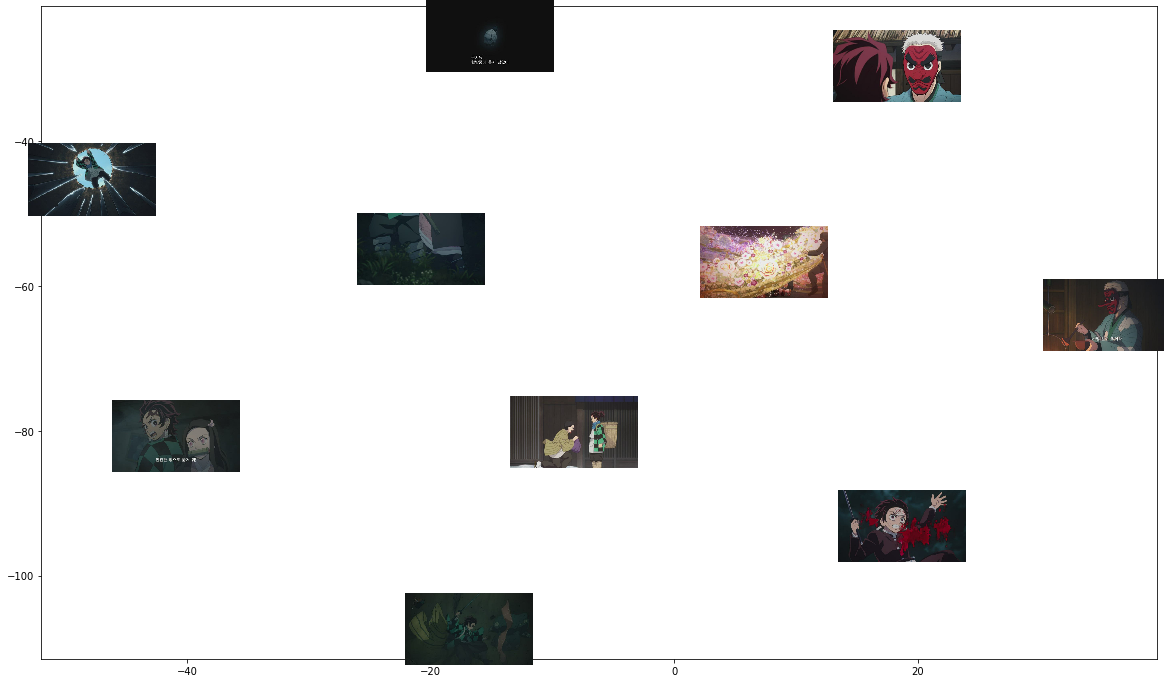

In [ ]:
# 2차원으로 차원 축소
n_components = 2

# t-sne 모델 생성
model = TSNE(n_components=n_components)

# 학습한 결과 2차원 공간 값 출력
kkk = model.fit_transform(cc)
    
plt.figure(figsize=(20, 12))
    
for j in range(len(kkk)):
  img_path = style_path[j]
  imscatter(kkk[j,0],kkk[j,1], image=img_path, zoom=0.2)
plt.show()
# 시드고정 하는법 알아오기




In [ ]:
pd.DataFrame({'img_name':img_name[0:10],
             'array':c})

,img_name,array
0,(무삭제) 귀멸의 칼날,"[[839.56537, 84.03049, 151.18427, 665.6687, 13..."
1,(무삭제) 귀멸의 칼날,"[[251.67714, 25.152975, 7.682108, 348.00922, 3..."
2,(무삭제) 귀멸의 칼날,"[[1294.695, 315.9809, 251.35341, 1139.8997, 20..."
3,(무삭제) 귀멸의 칼날,"[[504.74203, 57.65018, 62.375313, 491.96643, 7..."
4,(무삭제) 귀멸의 칼날,"[[846.3258, 66.83774, 118.601845, 743.30664, 1..."
5,(무삭제) 귀멸의 칼날,"[[1640.7915, 154.88434, 285.09116, 1181.2954, ..."
6,(무삭제) 귀멸의 칼날,"[[242.32742, 4.147858, 2.6953218, 347.4262, 35..."
7,(무삭제) 귀멸의 칼날,"[[1314.9353, 148.67963, 320.2533, 903.86285, 4..."
8,(무삭제) 귀멸의 칼날,"[[705.0615, 59.959587, 82.42309, 654.6773, 105..."
9,(무삭제) 귀멸의 칼날,"[[702.8636, 38.01857, 61.64514, 676.0097, 109...."


# 지워도돼

In [ ]:
#데이터 불러오기
import os
os.chdir("/content/drive/Shareddrives/행복 범주 화이팅!/image_vector")
df1 = pd.read_csv('vector1.csv')
df2 = pd.read_csv('vector2.csv')
df3 = pd.read_csv('vector3.csv')
df4 = pd.read_csv('vector4.csv')
df5 = pd.read_csv('vector5.csv')
df6 = pd.read_csv('vector6.csv')
df7 = pd.read_csv('vector7.csv')
df8 = pd.read_csv('vector8.csv')
df9 = pd.read_csv('vector9.csv')
df10 = pd.read_csv('vector10.csv')
df11 = pd.read_csv('vector11.csv')
df12 = pd.read_csv('vector12.csv')
df13 = pd.read_csv('vector13.csv')
df14 = pd.read_csv('vector14.csv')
df15 = pd.read_csv('vector15.csv')
df16 = pd.read_csv('vector16.csv')
df17 = pd.read_csv('vector17.csv')
df18 = pd.read_csv('vector18.csv')
df19 = pd.read_csv('vector19.csv')
df20 = pd.read_csv('vector20.csv')
df21 = pd.read_csv('vector21.csv')
df22 = pd.read_csv('vector22.csv')
df23 = pd.read_csv('vector23.csv')
df24 = pd.read_csv('vector24.csv')
df25 = pd.read_csv('vector25.csv')
df26 = pd.read_csv('vector26.csv')
df27 = pd.read_csv('vector27.csv')
df28 = pd.read_csv('vector28.csv')
df29= pd.read_csv('vector29.csv')
df30= pd.read_csv('vector30_temp.csv')
df31 = pd.read_csv('vector31_1333.csv')
vec = pd.concat([df1, df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13,df14,df15,df16,df17,df18,df19,df20,df21,df22,df23,df24,df25,df26,df27,df28,df29,df30,df31], axis = 0)

In [ ]:
len(vec['img_name'])

31334

In [ ]:
import pandas as pd
vec.to_csv('vector31334.csv',encoding='utf-8-sig')